In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from scipy import *
import numpy as np

## Traveling Salesman Problem (TSP)

Das Traveling Salesman Problem (TSP) ist ein bekanntes Problem in der Optimierung und Informatik.  
Dabei geht es darum, für einen reisenden Verkäufer die kürzeste Route zu finden, die eine vorgegebene  
Anzahl von Städten genau einmal besucht und am Ausgangspunkt endet. Das Ziel ist es, die  
Gesamtreisekosten oder -zeit zu minimieren.


Zufaellige Ablauffolge: 11 8 0 10 9 12 4 1 7 13 14 5 3 6 2
Summe der Entfernungen: 2510.1633422493533 



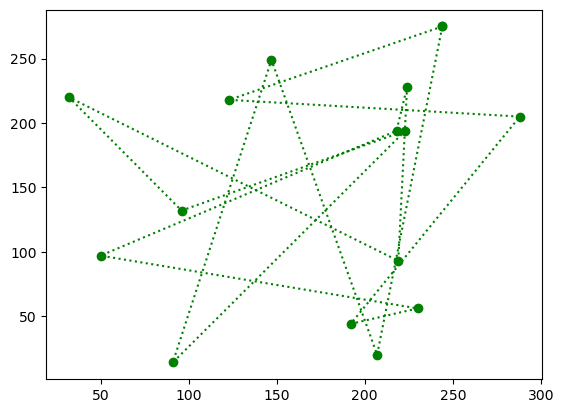

In [2]:
# Festlegung der Dimensionen
n = 15         # Anzahl der Standorte
m = n * 20     # Dimension des Raumes

# Wuerfeln der Standorte (Koordinaten)
x = np.random.randint(1, m+1, n)
y = np.random.randint(1, m+1, n)
Koord = np.column_stack((x, y))

# Bestimmung der Entfernungsmatrix
Entfernungsmatrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        Entfernungsmatrix[i, j] = np.linalg.norm(Koord[i] - Koord[j])

# Beliebiges Durchlaufen der Standorte
Folge = np.random.permutation(n)

# Berechnung der zurückgelegten Entfernung
Entf = Entfernungsmatrix[Folge[n-1], Folge[0]]

for i in range(n-1):
    Entf += Entfernungsmatrix[Folge[i], Folge[i+1]]

# Graphische Darstellung der Route
xx_0 = np.concatenate((x[Folge], [x[Folge[0]]]))
yy_0 = np.concatenate((y[Folge], [y[Folge[0]]]))
plt.plot(xx_0, yy_0, ':o', color='green', )

# Ausgabe der Informationen
print('\nZufaellige Ablauffolge:', ' '.join(map(str, Folge)))
print('Summe der Entfernungen:', Entf, '\n')


## Evolutionäre Algorithmen

Ein evolutionärer Algorithmus ist eine Optimierungsmethode, die von den Prinzipien der natürlichen Selektion und Evolution inspiriert ist.  
Er verwendet Mechanismen wie Mutation, Kreuzung und Selektion, um schrittweise bessere Lösungen für ein Problem zu finden.  
Evolutionäre Algorithmen beginnen mit einer Population von möglichen Lösungen und verbessern diese Generation für Generation.

Im Kontext des Traveling Salesman Problems (TSP) können evolutionäre Algorithmen verwendet werden, um gute Routen für den reisenden Verkäufer zu finden.  
Der Prozess beginnt mit einer zufälligen Auswahl von Routen. Durch Anwendung der oben genannten Mechanismen (Mutation und Kreuzung) werden neue Routen erzeugt.  
Die besten Routen (die kürzesten) werden ausgewählt, um die nächste Generation zu bilden. Dieser Prozess wiederholt sich, bis eine zufriedenstellende Lösung gefunden wird.

#### Funktionen des evolutionären Algorithmus:

In [3]:
# Zielfunktion: Minimierung der zurückgelegten Entfernung
def GetFitness(Indiviuum):
    Fit = Entfernungsmatrix[Indiviuum[n-1], Indiviuum[0]]
    for i in range(n-1):
        Fit += Entfernungsmatrix[Indiviuum[i], Indiviuum[i+1]]
    return Fit

# Rekomination zweier Ablauffolgen durch Ein-Punkt-Crossover
def CrossOver(Elter1, Elter2):
    cp = np.random.randint(1, n)
    Kind1 = np.concatenate((Elter1[:cp], np.setdiff1d(Elter2, Elter1[:cp])))
    Kind2 = np.concatenate((Elter2[:cp], np.setdiff1d(Elter1, Elter2[:cp])))
    zz = np.random.randint(0, 1)
    if zz == 0:
        return Kind1
    else:
        return Kind2

# Mutation einer Ablauffolge mit einer Wahrscheinlichkeit von α
def Mutation(Individuum, alpha):
    if np.random.rand() < alpha:
        i, j = np.random.choice(n, 2, replace=False)
        Individuum[i], Individuum[j] = Individuum[j], Individuum[i]
    return Individuum

# Selektion der nächsten Generation
def Selektion(Pop_Elter, Pop_Kinder, Fitness_Elter, Fitness_Kinder, μ):
    Pop_Elter = np.concatenate((Pop_Elter, Pop_Kinder))
    Fitness_Elter = np.concatenate((Fitness_Elter, Fitness_Kinder))
    Indizes = np.argsort(Fitness_Elter)
    Pop_Elter = Pop_Elter[Indizes]
    Fitness_Elter = Fitness_Elter[Indizes]
    return Pop_Elter[:μ], Fitness_Elter[:μ]

# Prüfen, ob sich die beste Lösung verbessert hat
def CheckChange(Best_Elter, Current_Elter):
    no_change = False
    if Best_Elter == Current_Elter:
        no_change = True
    return no_change

#### Durchführung der Optimierung:

In [4]:
'''
n_population = 250
crossover_per = 0.8
mutation_per = 0.2
n_generations = 200
'''

# Populationsgroesse
μ = 20*n

# Initialisierung der Population
P = np.zeros((μ, n), dtype=int)
for i in range(μ):
    P[i] = np.random.permutation(n)

# Anzahl der Nachkommen
λ = 7 * μ

# Mutationswahrscheinlichkeit
α = 1.0

# CrossOver-Wahrscheinlichkeit
β = 0.8

# Generationszaehler
g = 0

# Abbruchkriterium
max_generations = 1000
max_no_change = 50

# Counter für die Anzahl der Generationen ohne Verbesserung
no_change_counter = 0

# Berechnung der Fitnesswerte der Startpopulation
Fitness = np.zeros(μ)
for i in range(μ):
    Fitness[i] = GetFitness(P[i])

# Speicher für die besten Ablauffolgen
Best_Elter_xx = np.zeros((max_generations, n+1))
Best_Elter_yy = np.zeros((max_generations, n+1))

while g < max_generations:

    # Erzeugung von λ Nachkommen P_ durch Rekombination aus P(g)
    P_ = np.zeros((λ, n), dtype=int)
    P__ = np.zeros((λ, n), dtype=int)
    for i in range(λ):
        # Auswahl zweier Eltern aus P(g)
        Eltern = np.random.choice(μ, 2, replace=False)
        # Rekombination der Eltern
        P_[i] = CrossOver(P[Eltern[0]], P[Eltern[1]])
        # Mutation des Nachkommen
        P__[i] = Mutation(P_[i], α)

    # Berechnung der Fitnesswerte der Nachkommen
    Fitness__ = np.zeros(λ)
    for i in range(λ):
        Fitness__[i] = GetFitness(P__[i])

    # Sorierung der Nachkommen nach Fitness
    Indizes = np.argsort(Fitness__)
    P__ = P__[Indizes]
    Fitness__ = Fitness__[Indizes]

    # Prüfen, ob sich die beste Lösung verbessert hat
    if CheckChange(Fitness[0], Fitness__[0]):
        no_change_counter += 1
    else:
        no_change_counter = 0

    # Falls sich die beste Lösung seit 10 Generationen nicht verbessert hat
    if no_change_counter == max_no_change:
        # Lösche alle Elemente in Best_Elter_xx und Best_Elter_yy ab der aktuellen Generation

        # Ausgabe der Informationen
        print('Keine Verbesserung seit Generationen ', g+1-no_change_counter)
        print('Beste Ablauffolge:', ' '.join(map(str, P[0])))
        print('Summe der Entfernungen:', Fitness[0], '\n')
        break

    # Selektion der μ besten Individuen für P(g+1) aus P(g) und P__(g)
    P, Fitness = Selektion(P, P__, Fitness, Fitness__, μ)

    # Speichere die Koodinaten der besten Route in einer Liste
    Best_Elter_xx[g] = np.concatenate((x[P[0]], [x[P[0][0]]]))
    Best_Elter_yy[g] = np.concatenate((y[P[0]], [y[P[0][0]]]))

    print("Gen.: " + str(g+1) + "\nFit.: " + str(Fitness[0]) + "\nKeine Verbesserung seit: " + str(no_change_counter) + " Gen.\n")
    g += 1
    α = 1.0 - g/max_generations

# Plot der besten Route
# plt.plot(Best_Elter_xx[g+1-no_change_counter], Best_Elter_yy[g+1-no_change_counter], ':o', color='red', )
# plt.show()

Gen.: 1
Fit.: 1541.8358034958808
Keine Verbesserung seit: 0 Gen.

Gen.: 2
Fit.: 1366.2963139588076
Keine Verbesserung seit: 0 Gen.

Gen.: 3
Fit.: 1322.7548707559029
Keine Verbesserung seit: 0 Gen.

Gen.: 4
Fit.: 1309.4076057902973
Keine Verbesserung seit: 0 Gen.

Gen.: 5
Fit.: 1309.4076057902973
Keine Verbesserung seit: 0 Gen.

Gen.: 6
Fit.: 1183.0496441553285
Keine Verbesserung seit: 0 Gen.

Gen.: 7
Fit.: 1162.5603085314694
Keine Verbesserung seit: 0 Gen.

Gen.: 8
Fit.: 1162.5603085314694
Keine Verbesserung seit: 0 Gen.

Gen.: 9
Fit.: 1075.6336188188952
Keine Verbesserung seit: 0 Gen.

Gen.: 10
Fit.: 994.9067222129296
Keine Verbesserung seit: 0 Gen.

Gen.: 11
Fit.: 994.9067222129296
Keine Verbesserung seit: 0 Gen.

Gen.: 12
Fit.: 994.9067222129296
Keine Verbesserung seit: 0 Gen.

Gen.: 13
Fit.: 994.9067222129296
Keine Verbesserung seit: 0 Gen.

Gen.: 14
Fit.: 994.9067222129296
Keine Verbesserung seit: 1 Gen.

Gen.: 15
Fit.: 994.9067222129296
Keine Verbesserung seit: 0 Gen.

Gen.: 16
F

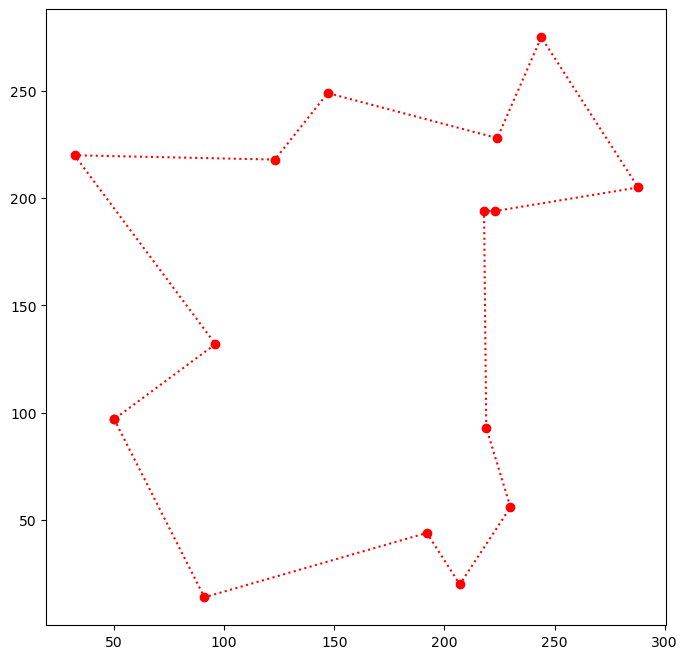

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

fig = plt.figure()
fig.set_size_inches(8, 8)
ax = fig.add_subplot(1, 1, 1) 

for i in range(g+1-no_change_counter):
    x = Best_Elter_xx[i]
    y = Best_Elter_yy[i]
    
    ax.set_xlim(0, i)
    
    ax.cla()
    ax.plot(x, y, ':o', color='red')
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.5)